In [1]:
%matplotlib inline
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

import ipywidgets as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

from datetime import datetime

Matplotlib settings:

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Global settings:

In [3]:
date_signature = datetime.now().strftime('%d_%h_%Y')
aperture_name = 'telescope'

# Loading the Data

Load the data: HA (deg), Dec (deg), dome azimuth (deg), $\Delta$HA (the maximum hour angle distance; in hours).

In [4]:
ha, dec, az, delta_ha = np.loadtxt('../scripts/data/optimal_azimuth_telescope_15_Jun_2021.csv', delimiter=',', unpack=True)

ha_shifted = np.where(ha < 0, ha + 360, ha) # offset ha, s.t. ha = (0, ..., 359)

# hd = np.column_stack([ha, dec])
hd = np.column_stack([ha_shifted, dec])

In [5]:
ha_min = ha_shifted.min()
ha_max = ha_shifted.max()

dec_min = dec.min()
dec_max = dec.max()

# Visualisation

## Colorplots

In [6]:
ha_range = np.arange(ha_shifted.min(), ha_shifted.max() + 1, 1)
dec_range = np.arange(dec.min(), dec.max() + 1, 1)

ha_grid, dec_grid = np.meshgrid(ha_range, dec_range, indexing='ij')

Create a $A_d$ grid for imshow from the 1D data...

In [7]:
az_grid = np.zeros(ha_grid.shape) * np.nan

for i in range(0, ha_range.size):
    for j in range(0, dec_range.size):
        h = ha_grid[i, j]
        d = dec_grid[i, j]
        
        sel = np.isclose(ha_shifted, h)&np.isclose(dec, d)
        if np.count_nonzero(sel) > 0:
            az_grid[i, j] = az[sel][0]
        else:
            az_grid[i, j] = np.nan

Create a $\Delta h$ grid for imshow from the 1D data...

In [8]:
delta_ha_grid = np.zeros(ha_grid.shape) * np.nan

for i in range(0, ha_range.size):
    for j in range(0, dec_range.size):
        h = ha_grid[i, j]
        d = dec_grid[i, j]
        
        sel = np.isclose(ha_shifted, h)&np.isclose(dec, d)
        if np.count_nonzero(sel) > 0:
            delta_ha_grid[i, j] = delta_ha[sel][0]
        else:
            delta_ha_grid[i, j] = np.nan

### Plotting $A_{\text{dome},\text{optimal}}=A_\text{d}\,(h,\delta)$

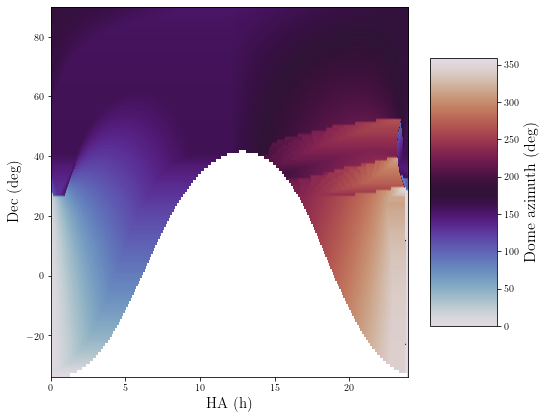

In [9]:
fig = plt.figure(figsize=(8, 8))
frame = fig.add_subplot(1, 1, 1)

frame.set_xlabel('HA (h)', fontsize=15)
frame.set_ylabel('Dec (deg)', fontsize=15)

az_grid_transposed = az_grid.T
az_field = frame.imshow(az_grid_transposed, aspect=0.2, origin='lower', extent=(ha_min/15, ha_max/15, dec_min, dec_max), 
                        vmin=0, vmax=359, cmap=cm.twilight)

col_bar = fig.colorbar(az_field, shrink=1, aspect=4)
col_bar.set_label('Dome azimuth (deg)', fontsize=16)

plt.show()

fig.savefig('images/optimal_azimuth_{}_{}.png'.format(aperture_name, date_signature), dpi=500)

### Time at each $(h,\delta)$

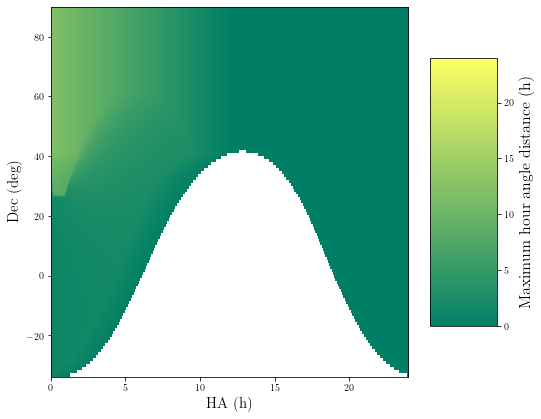

In [10]:
fig = plt.figure(figsize=(8, 8))
frame = fig.add_subplot(1, 1, 1)

frame.set_xlabel('HA (h)', fontsize=15)
frame.set_ylabel('Dec (deg)', fontsize=15)

delta_ha_grid_transposed = delta_ha_grid.T
delta_ha_field = frame.imshow(delta_ha_grid_transposed, aspect=0.2, origin='lower', extent=(ha_min/15, ha_max/15, dec_min, dec_max), 
                        vmin=0, vmax=24, cmap=cm.summer)

col_bar = fig.colorbar(delta_ha_field, shrink=1, aspect=4)
col_bar.set_label('Maximum hour angle distance (h)', fontsize=16)

plt.show()

fig.savefig('images/max_hour_angle_distance_{}_{}.png'.format(aperture_name, date_signature), dpi=500)

In [31]:
dec_senw = np.array([-36, 0, 36, 0])
ha_senw  = np.array([0, -6*15, 12*15, 6*15])

In [32]:
def make_polar(h, d):
    r = 90 - d
    x = r * np.cos(np.radians(h)+ 3*np.pi/2)
    y = r * np.sin(np.radians(h)+ 3*np.pi/2)
    
    return x, y

In [33]:
grid_x, grid_y = make_polar(ha_grid, dec_grid)
nesw_x, nesw_y = make_polar(ha_senw, dec_senw) # NESW markers
zen_x, zen_y = make_polar(0, 90-53) # Zenith

c_eq_x, c_eq_y = make_polar(ha_range, 0) # Celestial equator
c_36_x, c_36_y = make_polar(ha_range, 36-15) # (Artificial) horizon
cp_36_x, cp_36_y = make_polar(ha_range, 36+15) # circumpolar region

The following plot should probably use a $\log(\Delta\text{HA})$ scale!

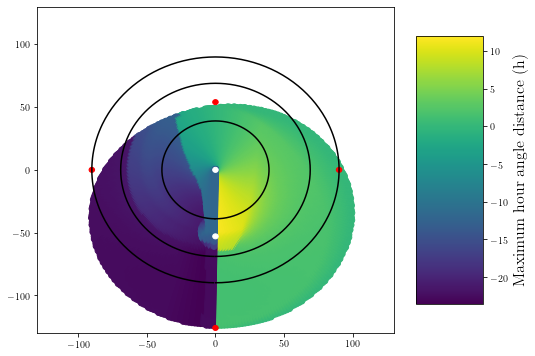

In [34]:
fig = plt.figure(figsize=(8, 6))
frame = fig.add_subplot(1, 1, 1)

cf = frame.scatter(grid_x, grid_y, c=delta_ha_grid)
# cf = frame.scatter(grid_x, grid_y, c=np.log10(delta_ha_grid))

col_bar = fig.colorbar(cf, shrink=1, aspect=4)
col_bar.set_label('Maximum hour angle distance (h)', fontsize=16)
# col_bar.set_label('log(Maximum hour angle distance) (h)', fontsize=16)

frame.plot(c_eq_x, c_eq_y, color='black', zorder=10)
frame.plot(c_36_x, c_36_y, color='black', zorder=10)
frame.plot(cp_36_x, cp_36_y, color='black', zorder=10)

ncp = plt.Circle((0, 0), 2, color='w')
frame.add_patch(ncp)

ncp = plt.Circle((zen_x, zen_y), 2, color='w')
frame.add_patch(ncp)

for x, y in zip(nesw_x, nesw_y):
    ncp = plt.Circle((x, y), 2, color='r')
    frame.add_patch(ncp)

frame.set_xlim(-130, 130)
frame.set_ylim(-130, 130)

plt.show()

fig.savefig('images/max_hour_angle_distance_polar_{}_{}.png'.format(aperture_name, date_signature), dpi=500)

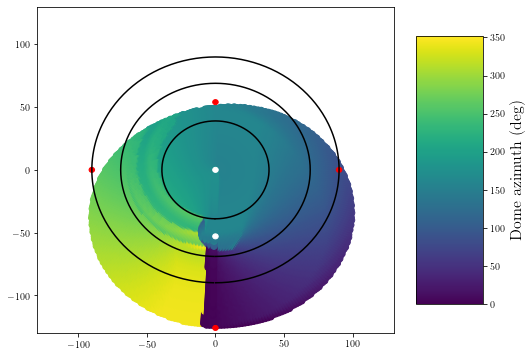

In [35]:
fig = plt.figure(figsize=(8, 6))
frame = fig.add_subplot(1, 1, 1)

cf = frame.scatter(grid_x, grid_y, c=az_grid)

col_bar = fig.colorbar(cf, shrink=1, aspect=4)
col_bar.set_label('Dome azimuth (deg)', fontsize=16)

ncp = plt.Circle((0, 0), 2, color='w')
frame.add_patch(ncp)

ncp = plt.Circle((zen_x, zen_y), 2, color='w')
frame.add_patch(ncp)

for x, y in zip(nesw_x, nesw_y):
    ncp = plt.Circle((x, y), 2, color='r')
    frame.add_patch(ncp)
    
frame.plot(c_eq_x, c_eq_y, color='black', zorder=10)
frame.plot(c_36_x, c_36_y, color='black', zorder=10)
frame.plot(cp_36_x, cp_36_y, color='black', zorder=10)

frame.set_xlim(-130, 130)
frame.set_ylim(-130, 130)

plt.show()

fig.savefig('images/dome_azimuth_polar_{}_{}.png'.format(aperture_name, date_signature), dpi=500)

# Where $\Delta A=|A_\text{telescope}-A_\text{dome}|>13\ \text{deg}$

In [36]:
def telescope_azimuth(ha, dec):
    phi = np.radians(53.3)
    a = np.radians(6.5)
    
#     y = -np.cos(np.radians(dec)*np.cos(phi)*np.sin(ha))
#     x = np.sin(dec)-np.sin(phi)*np.sin(a)
    
    r = 90-dec
    y = r*np.sin(np.radians(ha))
    
    delta = 90-53.3
    x = r*np.cos(np.radians(ha))-delta
    
    return np.degrees(np.arctan2(y, x))

In [37]:
tele_az = telescope_azimuth(ha_grid, dec_grid)
tele_az[tele_az < 0] = tele_az[tele_az < 0] + 360
tele_az[np.isnan(az_grid)] = np.nan

In [38]:
delta_az = 180 - np.abs(180-np.abs(tele_az - az_grid))

In [39]:
grid_x = grid_x[~np.isnan(delta_az)]
grid_y = grid_y[~np.isnan(delta_az)]
delta_az = delta_az[~np.isnan(delta_az)]

c = np.where(delta_az > 13, 1, 0)

## % where $\Delta A < 13\ \text{deg}$

In [40]:
c[c == 0].size/(c[c == 1].size+c[c == 0].size)

0.4959629806925164

## Polar $(h,\delta)$ plot

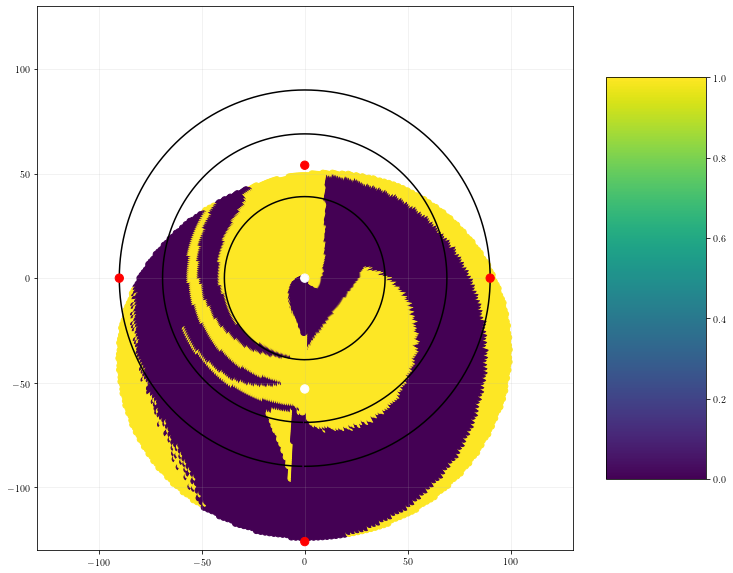

In [44]:
fig = plt.figure(figsize=(12, 10))
frame = fig.add_subplot(1, 1, 1)

cf = frame.scatter(grid_x, grid_y, c=c)

col_bar = fig.colorbar(cf, shrink=1, aspect=4)
# col_bar.set_label('', fontsize=16)

ncp = plt.Circle((0, 0), 2, color='w', zorder=12)
frame.add_patch(ncp)

ncp = plt.Circle((zen_x, zen_y), 2, color='w', zorder=12)
frame.add_patch(ncp)

for x, y in zip(nesw_x, nesw_y):
    ncp = plt.Circle((x, y), 2, color='r', zorder=12)
    frame.add_patch(ncp)
    
frame.plot(c_eq_x, c_eq_y, color='black', zorder=10)
frame.plot(c_36_x, c_36_y, color='black', zorder=10)
frame.plot(cp_36_x, cp_36_y, color='black', zorder=10)

frame.set_xlim(-130, 130)
frame.set_ylim(-130, 130)

frame.grid(alpha=0.2)

# plt.axis('off')
plt.show()
fig.savefig('images/good_or_bad_{}_{}.png'.format(aperture_name, date_signature), dpi=500)